In this notebook, I will demonstrate how to train a DDPG algorithm using fastText embeddings for item representations and an MLP-based policy.

In [ ]:
%%capture
!pip install gymnasium stable-baselines3 'shimmy>=2.0'

In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
from collections import Counter
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_util import make_vec_env

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from custom_env import RecommendationEnv
from reward_simulator import StateActionRewardProcessor

from utils import dcg_at_k, ndcg_at_k, precision_at_k, recall_at_k, is_hit, calc_for_user, load_fasttext_embeddings

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = '/content/drive/MyDrive/ML/Reinforcement Learning/Final project/MIND'

In [ ]:
merged_behaviors_path = os.path.join(project_dir, 'processed_data/merged_behaviors_train.csv')
merged_behaviors = pd.read_csv(merged_behaviors_path)

embeddings_path_fasttext = os.path.join(project_dir, 'embeddings/news_train_fasttext_embeddings.pkl')

processor = StateActionRewardProcessor(merged_behaviors, embeddings_path_fasttext, alpha=0.5)

embeddings_dict = processor.embeddings_dict

Processing sessions: 100%|██████████| 49108/49108 [00:22<00:00, 2231.18it/s]
Computing state-action embeddings: 1361705it [04:11, 5417.59it/s]


In [ ]:
env = RecommendationEnv(merged_behaviors, embeddings_dict, processor)

In [3]:
n_actions = env.action_space.shape[-1]
ou_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.05 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=ou_noise, tensorboard_log="./ddpg_tensorboard/", verbose=1)

In [4]:
model.learn(total_timesteps = 20_000)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./ddpg_tensorboard/

In [ ]:
event_path = '/content/ddpg_tensorboard/DDPG_1/events.out.tfevents.1742559280.f5d20aa4c454.1042.0'
event_acc = EventAccumulator(event_path)
event_acc.Reload()

scalar_name = "rollout/ep_rew_mean"
reward_scalars = event_acc.Scalars(scalar_name)

scalar_name = "rollout/ep_len_mean"
length_scalars = event_acc.Scalars(scalar_name)

reward_df = pd.DataFrame([(s.step, s.wall_time, s.value) for s in reward_scalars], columns=["Step", "WallTime", "Value"])
length_df = pd.DataFrame([(s.step, s.wall_time, s.value) for s in length_scalars], columns=["Step", "WallTime", "Value"])

reward_path = os.path.join(project_dir, 'results/ddpg_baseline_rewards.csv')
length_path = os.path.join(project_dir, 'results/ddpg_baseline_lengths.csv')

reward_df.to_csv(reward_path, index=False)
length_df.to_csv(length_path, index=False)

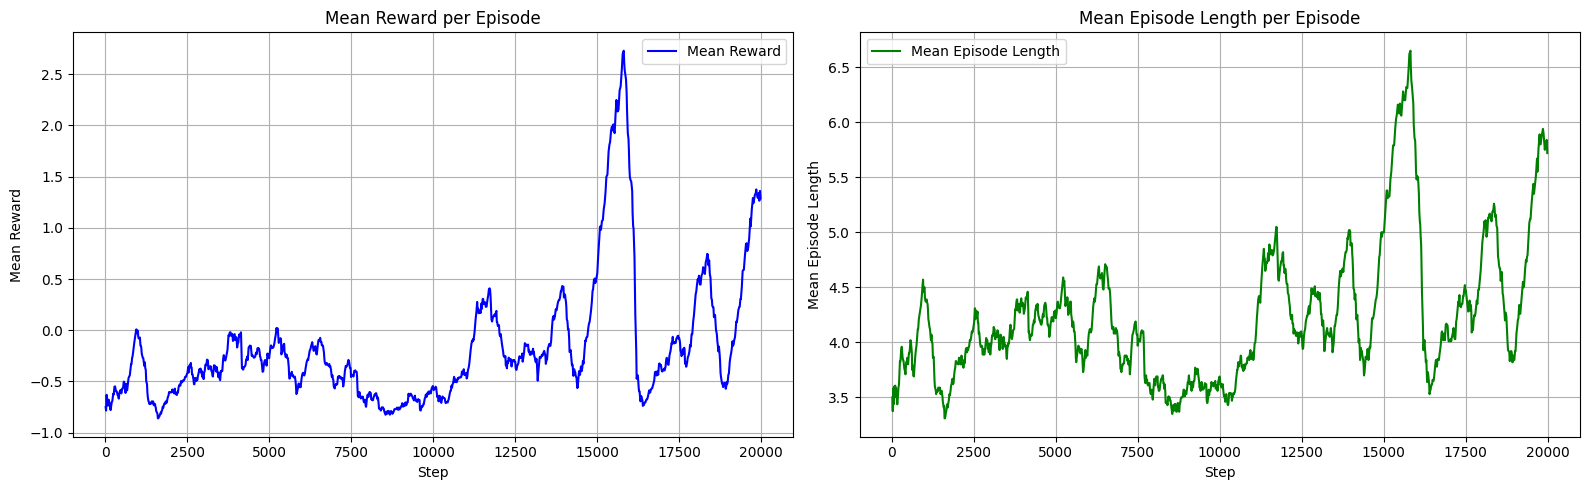

In [ ]:
reward_df = pd.read_csv(reward_path)
length_df = pd.read_csv(length_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(reward_df["Step"], reward_df["Value"], label="Mean Reward", color='b')
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Mean Reward")
axes[0].set_title("Mean Reward per Episode")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(length_df["Step"], length_df["Value"], label="Mean Episode Length", color='g')
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Mean Episode Length")
axes[1].set_title("Mean Episode Length per Episode")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# model.save("ddpg_baseline")

## Predict for a single user

In [ ]:
news_train_path = os.path.join(project_dir, 'MINDsmall_train/news.tsv')
news_train = pd.read_csv(news_train_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [5]:
merged_behaviors['user_id'].values[:100]

In [ ]:
# Choose user

USER_ID = 'U9993'

In [ ]:
user_hist = merged_behaviors[merged_behaviors['user_id'] == USER_ID].iloc[0, 1].split()
user_imressions = [i.split('-')[0] for i in merged_behaviors[merged_behaviors['user_id'] == USER_ID].iloc[0, 2].split()]

In [ ]:
user_hist[:5]

['N47458', 'N14114']

In [ ]:
user_imressions[:5]

['N28918', 'N53515', 'N34869', 'N37204', 'N15574']

In [ ]:
obs = env.reset(user_hist)

In [6]:
print(env.user_history)
for i in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"New history: {env.user_history}")
    print(f"Recommended: {env.recommended}")
    print(f"Rewards: {env.rewards}")

In [ ]:
news_train[news_train['news_id'].isin(user_hist)]

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
20912,N14114,entertainment,news,Christopher Dennis Dies: 'Hollywood Superman' ...,Hollywood Boulevard is in mourning for a lost ...,https://assets.msn.com/labs/mind/AAJY0Kz.html,"[{""Label"": ""Jimmy Kimmel Live!"", ""Type"": ""W"", ...","[{""Label"": ""Hollywood Boulevard"", ""Type"": ""S"",..."
23231,N47458,news,newscrime,"1 dead, 2 injured, suspect still at large afte...",Three employees were shot Wednesday evening at...,https://assets.msn.com/labs/mind/AAJZvuH.html,"[{""Label"": ""Church's Chicken"", ""Type"": ""O"", ""W...","[{""Label"": ""Church's Chicken"", ""Type"": ""O"", ""W..."


In [ ]:
news_train[news_train['news_id'].isin(env.recommended)]

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
782,N24137,news,newsus,Woman Dies After Head-On Collision In Brookline,One woman is dead following a two-vehicle acci...,https://assets.msn.com/labs/mind/AAJJdRu.html,"[{""Label"": ""Brookline, Massachusetts"", ""Type"":...","[{""Label"": ""Brookline, Massachusetts"", ""Type"":..."
3162,N23164,news,newscrime,Wheels stolen from cars parked at Logan Expres...,Police are investigating and patrols are being...,https://assets.msn.com/labs/mind/AAJEgAF.html,[],"[{""Label"": ""Massachusetts Port Authority"", ""Ty..."
4626,N54833,news,newsus,Gun Used In Santa Rosa School Shooting Found; ...,Detectives investigating a shooting outside a ...,https://assets.msn.com/labs/mind/AAJggsz.html,"[{""Label"": ""Santa Rosa, California"", ""Type"": ""...","[{""Label"": ""Santa Rosa, California"", ""Type"": ""..."
5851,N28752,news,newsus,Passenger dies in crash caused by wrong-way dr...,A passenger in a car going the wrong way on a ...,https://assets.msn.com/labs/mind/AAJrTiu.html,"[{""Label"": ""Kansas City, Missouri"", ""Type"": ""G...","[{""Label"": ""Dodge Dart"", ""Type"": ""V"", ""Wikidat..."
5855,N53581,news,newsus,Gunman left Grand Prairie man dead in Arlingto...,FORT WORTH -- A Grand Prairie man was found sh...,https://assets.msn.com/labs/mind/AAISS1A.html,"[{""Label"": ""Arlington, Texas"", ""Type"": ""G"", ""W...","[{""Label"": ""Arlington, Texas"", ""Type"": ""G"", ""W..."
6912,N17158,news,newsus,Suspect With Outstanding Arrest Warrant In Cus...,This incident happened on the 500 block of Nor...,https://assets.msn.com/labs/mind/AAIIVeL.html,[],"[{""Label"": ""Broad Street (Philadelphia)"", ""Typ..."
7050,N63240,news,newscrime,Police investigating after body found in Green...,"GREENSBORO, N.C. Greensboro police are looki...",https://assets.msn.com/labs/mind/AAIOSCN.html,"[{""Label"": ""Greensboro, North Carolina"", ""Type...","[{""Label"": ""Greensboro, North Carolina"", ""Type..."
7448,N26400,lifestyle,lifestylebuzz,"Alleged serial car burglar, dubbed 'Red Shoes'...",NaN,https://assets.msn.com/labs/mind/AAISUiy.html,"[{""Label"": ""Westchester County, New York"", ""Ty...",[]
8347,N63370,news,newsus,"Police: Driver struck, injured woman walking t...",NaN,https://assets.msn.com/labs/mind/AAJL8Wi.html,"[{""Label"": ""Long Island"", ""Type"": ""L"", ""Wikida...",[]
10372,N10882,sports,more_sports,"Man reportedly 'smoked crack,' had son in car ...",NaN,https://assets.msn.com/labs/mind/AAJaix5.html,"[{""Label"": ""Charlotte, North Carolina"", ""Type""...",[]


In [ ]:
indices = np.where(np.array(env.rewards) == 1)
will_click = np.array(env.recommended)[indices]

In [7]:
news_train[news_train['news_id'].isin(will_click)]

## Measuring quality on train and evaluation sets

### train

In [ ]:
ndcg_scores = []
precision_scores = []
recall_scores = []
hits = []

for USER_ID in merged_behaviors['user_id'].sample(n=1000, random_state=99):
    ndcg_score, precision_score, recall_score, hit_score = calc_for_user(USER_ID, merged_behaviors, 12, 3, 10, env, model)

    ndcg_scores.append(ndcg_score)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    hits.append(hit_score)

In [8]:
print(f"Mean NDCG: {round(np.mean(ndcg_scores), 3)}")
print(f"Mean precision: {round(np.mean(precision_scores), 3)}")
print(f"Mean recall: {round(np.mean(recall_scores), 3)}")
print(f"Mean hit rate: {round(np.mean(hits), 3)}")

### dev

In [ ]:
embeddings_dev_path = os.path.join(project_dir, 'embeddings/news_dev_fasttext_embeddings.pkl')
embeddings_dev_dict = load_fasttext_embeddings(embeddings_dev_path)

behaviors_dev_path = os.path.join(project_dir, 'processed_data/merged_behaviors_dev.csv')
merged_behaviors_dev = pd.read_csv(behaviors_dev_path)

In [ ]:
merged_behaviors_dev.head()

,user_id,history,impressions
0,U1,N23571 N58267 N25682 N10646 N32607 N57737 N523...,N14637-0 N20036-1
1,U10,N27612 N36699 N64777 N9120 N9803 N57967 N2945,N33397-0 N46917-0 N11930-0 N58612-0 N47612-0 N...
2,U10000,N10059 N46978 N53234 N3345 N3345 N9155 N9653 N...,N29393-0 N20036-0 N30290-0 N31958-1 N23513-0 N...
3,U10002,N27448 N10059 N28467 N64777 N18881 N33117 N129...,N29862-0 N60724-0 N42844-0 N6916-0 N26485-0 N2...
4,U10004,N38118 N55805 N43482 N15402 N15627 N18870 N526...,N29379-0 N5472-0 N36779-1 N20036-0 N31958-0 N4...


In [ ]:
dev_env = RecommendationEnv(merged_behaviors_dev, embeddings_dev_dict, processor)

In [ ]:
ndcg_scores = []
precision_scores = []
recall_scores = []
hits = []

for USER_ID in merged_behaviors_dev['user_id'].sample(n=1000, random_state=99):
    ndcg_score, precision_score, recall_score, hit_score = calc_for_user(USER_ID, merged_behaviors_dev, 12, 3, 10, dev_env, model)

    ndcg_scores.append(ndcg_score)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    hits.append(hit_score)

In [9]:
print(f"Mean NDCG: {round(np.mean(ndcg_scores), 3)}")
print(f"Mean precision: {round(np.mean(precision_scores), 3)}")
print(f"Mean recall: {round(np.mean(recall_scores), 3)}")
print(f"Mean hit rate: {round(np.mean(hits), 3)}")